# Explore worst case scenario

Expore the worst case scenarios when "doing nothing" (zero policies).

Steps:

- Assign reference policy (with all levers = 0, i.e., the policy object `policy0`)
- Change the directions of outcomes (so that the found solutions are "undesirable", or, the worst cases)
- Run optimisation, search over uncertainties, and find the worst case scenarios

In [4]:
import os

if not os.path.exists('results'):
    os.mkdir('results') # create folder for storing results if doesn't exist

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from ema_workbench import (MultiprocessingEvaluator, 
                           Scenario, Constraint, Policy,
                           ScalarOutcome)
from ema_workbench.em_framework.optimization import EpsilonProgress, HyperVolume
from ema_workbench.em_framework.evaluators import perform_experiments, optimize
from ema_workbench.util import ema_logging, save_results, load_results
from ema_workbench.analysis import (pairs_plotting, prim, 
                                    feature_scoring, parcoords,
                                    dimensional_stacking)

from problem_formulation import get_model_for_problem_formulation
%matplotlib inline

ema_logging.log_to_stderr(ema_logging.INFO)

C:\ProgramData\Anaconda3\lib\importlib\_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)


<Logger EMA (DEBUG)>

In [3]:
'''
For different list of outcomes:
# 0 = 2-objective PF
# 1 = 3-objective PF
# 2 = 5-objective PF
# 3 = Disaggregate over locations
# 4 = Disaggregate over time
# 5 = Fully disaggregated
'''
dike_model, planning_steps = get_model_for_problem_formulation(2) # assign problem_formulation_id

In [4]:
for uncertainties in dike_model.uncertainties:
    print(repr(uncertainties))

CategoricalParameter('discount rate 0', [0, 1, 2, 3])
CategoricalParameter('discount rate 1', [0, 1, 2, 3])
CategoricalParameter('discount rate 2', [0, 1, 2, 3])
IntegerParameter('A.0_ID flood wave shape', 0, 132)
RealParameter('A.1_Bmax', 30, 350)
RealParameter('A.1_pfail', 0, 1)
CategoricalParameter('A.1_Brate', [0, 1, 2])
RealParameter('A.2_Bmax', 30, 350)
RealParameter('A.2_pfail', 0, 1)
CategoricalParameter('A.2_Brate', [0, 1, 2])
RealParameter('A.3_Bmax', 30, 350)
RealParameter('A.3_pfail', 0, 1)
CategoricalParameter('A.3_Brate', [0, 1, 2])
RealParameter('A.4_Bmax', 30, 350)
RealParameter('A.4_pfail', 0, 1)
CategoricalParameter('A.4_Brate', [0, 1, 2])
RealParameter('A.5_Bmax', 30, 350)
RealParameter('A.5_pfail', 0, 1)
CategoricalParameter('A.5_Brate', [0, 1, 2])


In [5]:
# with no policies
ref_policy = {'DikeIncrease': 0, 'DaysToThreat': 0, 'RfR': 0}

policy0 = {}
for key in dike_model.levers:
    s1, s2 = key.name.split('_')
    if ' ' in s2:
        s2, s3 = s2.split(' ')
    policy0.update({key.name: ref_policy[s2]})                

policy0 = Policy('Policy 0', **policy0)

In [6]:
# change outcomes so direction is undesirable
minimize = ScalarOutcome.MINIMIZE
maximize = ScalarOutcome.MAXIMIZE

for outcome in dike_model.outcomes:
    if outcome.kind == minimize:
        outcome.kind = maximize
    else:
        outcome.kind = minimize

In [7]:
for outcomes in dike_model.outcomes:
    print(repr(outcomes))

ScalarOutcome('Expected Annual Damage', variable_name=['A.1_Expected Annual Damage 0', 'A.2_Expected Annual Damage 0', 'A.3_Expected Annual Damage 0', 'A.4_Expected Annual Damage 0', 'A.5_Expected Annual Damage 0', 'A.1_Expected Annual Damage 1', 'A.2_Expected Annual Damage 1', 'A.3_Expected Annual Damage 1', 'A.4_Expected Annual Damage 1', 'A.5_Expected Annual Damage 1', 'A.1_Expected Annual Damage 2', 'A.2_Expected Annual Damage 2', 'A.3_Expected Annual Damage 2', 'A.4_Expected Annual Damage 2', 'A.5_Expected Annual Damage 2'], function=<function sum_over at 0x000002332F825378>)
ScalarOutcome('Dike Investment Costs', variable_name=['A.1_Dike Investment Costs 0', 'A.2_Dike Investment Costs 0', 'A.3_Dike Investment Costs 0', 'A.4_Dike Investment Costs 0', 'A.5_Dike Investment Costs 0', 'A.1_Dike Investment Costs 1', 'A.2_Dike Investment Costs 1', 'A.3_Dike Investment Costs 1', 'A.4_Dike Investment Costs 1', 'A.5_Dike Investment Costs 1', 'A.1_Dike Investment Costs 2', 'A.2_Dike Investm

In [8]:
n_scenarios = 5000

# Assign for five outcomes respectively:
#  Expected annual damage, Dike investment costs : expect large values
#  RfR investment costs, Evcauation costs, Expected number of deaths : expect values close to zero
espilon = [1e2, 1e2, 1, 1, 1]
convergence_metrics = [HyperVolume(minimum=[0, 0, 0, 0, 0], 
                                   maximum=[1e10, 6e9, 0.01, 0.01, 1]),
                       EpsilonProgress()]

In [9]:
%%time
with MultiprocessingEvaluator(dike_model) as evaluator:
    results = evaluator.optimize(nfe=n_scenarios, 
                                 searchover='uncertainties',
                                 epsilons=espilon,
                                 convergence=convergence_metrics,
                                 reference = policy0)

save_results(results, './results/policy0 5000runs_worst case scenario.tar.gz')

[MainProcess/INFO] pool started
[MainProcess/INFO] generation 0: 0/5000 nfe
[MainProcess/INFO] generation 5: 500/5000 nfe
[MainProcess/INFO] generation 10: 1000/5000 nfe
[MainProcess/INFO] generation 15: 1500/5000 nfe
[MainProcess/INFO] generation 20: 2000/5000 nfe
[MainProcess/INFO] generation 25: 2500/5000 nfe
[MainProcess/INFO] generation 30: 3000/5000 nfe
[MainProcess/INFO] generation 35: 3500/5000 nfe
[MainProcess/INFO] generation 40: 4000/5000 nfe
[MainProcess/INFO] generation 45: 4500/5000 nfe
[MainProcess/INFO] optimization completed, found 2 solutions
[MainProcess/INFO] terminating pool
[MainProcess/INFO] results saved successfully to D:\epa1361_open\final assignment\policy0 5000runs_worst case scenario.tar.gz


Wall time: 54min 29s


In [10]:
results = load_results('./results/policy0 5000runs_worst case scenario.tar.gz')

scenarios, convergence = results

[MainProcess/INFO] results loaded succesfully from D:\epa1361_open\final assignment\policy0 5000runs_worst case scenario.tar.gz


Text(0.5, 0, 'number of function evaluations')

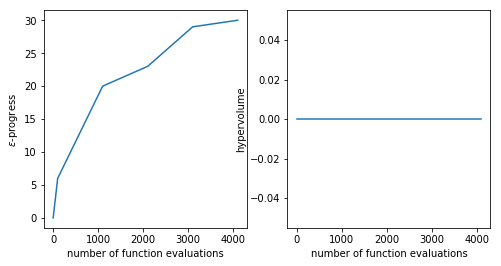

In [11]:
# check convergence
fig, (ax1, ax2) = plt.subplots(ncols=2, sharex=True, figsize=(8,4))
ax1.plot(convergence['nfe'], convergence['epsilon_progress'])
ax1.set_ylabel('$\epsilon$-progress')
ax2.plot(convergence['nfe'], convergence['hypervolume'])
ax2.set_ylabel('hypervolume')

ax1.set_xlabel('number of function evaluations')
ax2.set_xlabel('number of function evaluations')

In [13]:
# take a look at the results (only 2 solutions found!)
scenarios

,discount rate 0,discount rate 1,discount rate 2,A.0_ID flood wave shape,A.1_Bmax,A.1_pfail,A.1_Brate,A.2_Bmax,A.2_pfail,A.2_Brate,...,A.4_pfail,A.4_Brate,A.5_Bmax,A.5_pfail,A.5_Brate,Expected Annual Damage,Dike Investment Costs,RfR Investment Costs,Evacuation Costs,Expected Number of Deaths
0,"Category('1.5', 1.5)","Category('1.5', 1.5)","Category('1.5', 1.5)",34,30.178195,0.169120,"Category('1.5', 1.5)",39.588324,0.000626,"Category('1.0', 1.0)",...,0.726142,"Category('1.5', 1.5)",32.465404,0.000006,"Category('1.0', 1.0)",9.406121e+09,0,0.0,0.0,6.952634
1,"Category('1.5', 1.5)","Category('2.5', 2.5)","Category('2.5', 2.5)",105,30.254663,0.296934,"Category('1.5', 1.5)",30.017333,0.001485,"Category('1.5', 1.5)",...,0.894234,"Category('1.5', 1.5)",178.386627,0.000007,"Category('1.5', 1.5)",8.053987e+09,0,0.0,0.0,7.044994


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:334: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


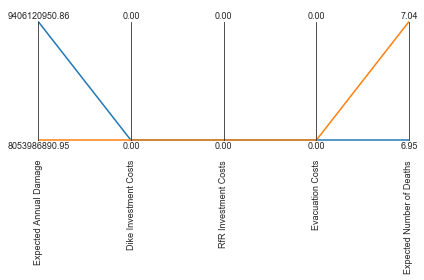

In [16]:
# show the relation among outcomes
outcomes = scenarios.loc[:, [o.name for o in dike_model.outcomes]]
limits = parcoords.get_limits(outcomes)

paraxes = parcoords.ParallelAxes(limits, fontsize=9)
paraxes.plot(outcomes)